In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score 
from sklearn import metrics

KMEANS_ITERATIONS = 100
NR_CLUSTERS = 10
HOG_SIZE = 144
VOCABULARY_SIZE = 300
KEY_POINT_SIZE = 32
EDGETHRESHOLD = 20


matrix_transforms = v2.Compose([
    ToTensor(),
    Normalize(0.5, 0.5),
    Resize((64, 64))
])

def plot_losses(train_losses: list[float], validation_losses: list[float]) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(validation_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

FASHION_BATCH_SIZE = 200

def get_fashion_dataloader(size : int):
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=matrix_transforms)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=matrix_transforms)
    train_dataloader = DataLoader(train_data, batch_size=size, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=size, shuffle=False)
    return train_data, test_data, train_dataloader, test_dataloader

train_fashion_dataset, test_fashion_dataset, train_fashion_dataloader, test_fashion_dataloader = get_fashion_dataloader(FASHION_BATCH_SIZE)
FASHION_KEYS = np.unique(train_fashion_dataset.targets)

In [89]:
class InfoLoaderDataset(Dataset):
    def __init__(self, data, labels, num_classes, transforms = None):
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.transforms == None):
            return self.data[idx], self.labels[idx]
        data = self.data[idx].detach().numpy()
        return self.transforms(data), self.labels[idx]
    
def intialiseParameters(model, optimizer_lr, gamma_lr, weight_decay_factor, milestones):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_lr, weight_decay=weight_decay_factor)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma_lr, last_epoch=-1)
    return criterion, optimizer, lr_scheduler

def train(model, dataloader, optimizer, criterion, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    train_loss = 0
    all_preds = []
    all_labels= []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return train_loss / batch_size, accuracy_score(all_preds, all_labels)

def test(model, dataloader, criterion, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        all_preds = []
        all_labels= []
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels.type(torch.LongTensor)).item()
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        return validation_loss / batch_size, accuracy_score(all_preds, all_labels), all_preds, all_labels
    
def train_model(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, batch_size, epochs):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    for i in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, batch_size)
        print("epoch ", i)
        val_loss, val_acc, _, _ = test(model, validation_dataloader, criterion, batch_size)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        lr_scheduler.step()
    return train_info

def test_model(model, dataloader, criterion, batch_size):
    loss, accuracy, pred, labels = test(model, dataloader, criterion, batch_size)
    print("loss was:", loss, " accuracy was:", accuracy)
    confusion_matrix = metrics.confusion_matrix(labels, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cm_display.plot()
    plt.show()


In [ ]:
# Task 1
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from task1_aux import compute_vocabulary, create_initial_features, compute_attributes
pd.set_option("display.precision", 15)
BATCH_SIZE = 25

# DE ADAUGAT TRANSFORMARI
vocabulary = compute_vocabulary(train_fashion_dataloader, 5)
print(vocabulary.shape)

STEP = 500
for i in range(0, 3):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, y_train = create_initial_features(train_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE, 50)
    X_test, y_test = create_initial_features(test_fashion_dataloader, vocabulary, FASHION_BATCH_SIZE, 50)
    rf.fit(X_train, y_train)
    accuracy_before = rf.score(X_test, y_test)
    print(f'accuracy after one more step', accuracy_before)
    importances = rf.feature_importances_
    feature_names = range(vocabulary.shape[0])
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    if (vocabulary.shape[0] > STEP):
        top_features = feature_importance_df['Feature'][:vocabulary.shape[0] - STEP].values
    else:
        top_features = feature_importance_df['Feature'][:64].values
    vocabulary = vocabulary[top_features]

print(vocabulary.shape)
X_train, y_train, X_validation, y_validation, X_test, y_test = compute_attributes(vocabulary, 
                            train_fashion_dataloader,  test_fashion_dataloader, FASHION_BATCH_SIZE)
feature_train_dataloader = DataLoader(InfoLoaderDataset(X_train, y_train, 10), BATCH_SIZE, shuffle=True)
feature_validation_dataloader = DataLoader(InfoLoaderDataset(X_validation, y_validation, 10), BATCH_SIZE, shuffle=True)
feature_test_dataloader = DataLoader(InfoLoaderDataset(X_test, y_test, 10), BATCH_SIZE, shuffle=True)

In [ ]:
from models import MLP
model = MLP()
train_losses, validation_losses, validation_metrics = train_loop(model, feature_train_dataloader, feature_validation_dataloader, 40)
plot_losses(train_losses, validation_losses)

In [24]:
# Task 2
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100
EPOCHS = 20
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.9
WEIGHT_DECAY_FACTOR = 1e-3
MILESTONES = range(0, EPOCHS, 5)
VALIDATION = 0.2

transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets 
# DUMNEZEU CU MILA
print(X_train[0].max(), X_train[0].min(), X_train[0].shape)
print(X_test[0].max(), X_test[0].min(), X_test[0].shape)

fullImg_train_dataloader = DataLoader(InfoLoaderDataset(X_train, y_train, 10, transforms), BATCH_SIZE, shuffle=True)
fullImg_validation_dataloader = DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, transforms), BATCH_SIZE, shuffle=True)
fullImg_test_dataloader = DataLoader(InfoLoaderDataset(X_test, y_test, 10, transforms), BATCH_SIZE, shuffle=True)

tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) torch.Size([28, 28])
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) torch.Size([28, 28])


In [25]:
class FullImageMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(FullImageMLP, self).__init__()
        self.fc1 = nn.Linear(784, 250)
        self.bn1 = nn.BatchNorm1d(250) 
        self.fc2 = nn.Linear(250, 250) 
        self.bn2 = nn.BatchNorm1d(250)
        self.fc3 = nn.Linear(250, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        return self.softmax(self.fc3(x))

In [ ]:
model = FullImageMLP()
criterion, optimizer, lr_scheduler = intialiseParameters(model, LR_OPTIMIZER, GAMMA_LR,WEIGHT_DECAY_FACTOR, MILESTONES)
train_info = train_model(model, fullImg_train_dataloader, fullImg_validation_dataloader, criterion, optimizer, 
                         lr_scheduler, BATCH_SIZE, EPOCHS)
torch.save(model.state_dict(), "./mlp.pth")
plot_losses(train_info["train_loss"], train_info["validation_loss"])
plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"])
test_model(model, fullImg_test_dataloader, criterion, BATCH_SIZE)


In [92]:
# Task 3
from task1_aux import split_data_in_training_validation
SIZE = (28, 28)
BATCH_SIZE = 100
EPOCHS = 20
LR_OPTIMIZER = 1e-4
GAMMA_LR = 0.9
WEIGHT_DECAY_FACTOR = 1e-3
MILESTONES = range(0, EPOCHS, 5)
VALIDATION = 0.2
BASE_DEPTH = 8
EXPANSION = 2
NR_LAYERS_BLOCK = 1

training_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),
])

testing_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE),
    Normalize(0.5, 0.5),

])
X_train, y_train, X_validation, y_validation = split_data_in_training_validation(train_fashion_dataset.data,
                                                    train_fashion_dataset.targets, FASHION_KEYS, VALIDATION)
X_test, y_test = test_fashion_dataset.data, test_fashion_dataset.targets
fullImg_train_dataloader = DataLoader(InfoLoaderDataset(X_train, y_train, 10, training_transforms), BATCH_SIZE, shuffle=True)
fullImg_validation_dataloader = DataLoader(InfoLoaderDataset(X_validation, y_validation, 10, testing_transforms), BATCH_SIZE, shuffle=True)
fullImg_test_dataloader = DataLoader(InfoLoaderDataset(X_test, y_test, 10, testing_transforms), BATCH_SIZE, shuffle=True)

In [93]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer):
        super(ConvBlock, self).__init__()
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out += identity
        out = self.relu(out)
        return out
    
class DeepConvNet(nn.Module):
    def __init__(self, base_depth=BASE_DEPTH, expansion=EXPANSION, nr_layer_blocks=NR_LAYERS_BLOCK, num_classes=10):
        super(DeepConvNet, self).__init__()
        self.base_depth = base_depth
        # convert image to grayscale before applying transformation
        self.conv1 = nn.Conv2d(1, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.relu = nn.ReLU(inplace=True)
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = nn.BatchNorm2d(depth1)
        # # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        self.conv_depth2 = conv1x1(depth1, depth2, 2)
        self.norm_depth2 = nn.BatchNorm2d(depth2)

        # #### Layer 2, 3 blocks
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        self.conv_depth3 = conv1x1(depth2, depth3, 2)
        self.norm_depth3 = nn.BatchNorm2d(depth3)

        # Layer 3, 3 blocks
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, nn.BatchNorm2d)] * nr_layer_blocks
        )

        # # AveragePooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(depth3, num_classes)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.layer1(x)

        x = self.relu(self.conv_depth2(x))
        x = self.norm_depth2(x)
        x = self.layer2(x)

        x = self.conv_depth3(x)
        x = self.norm_depth3(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19


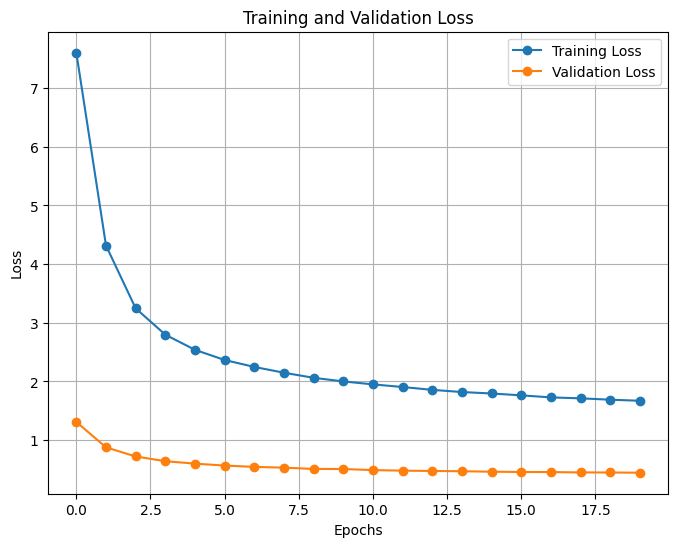

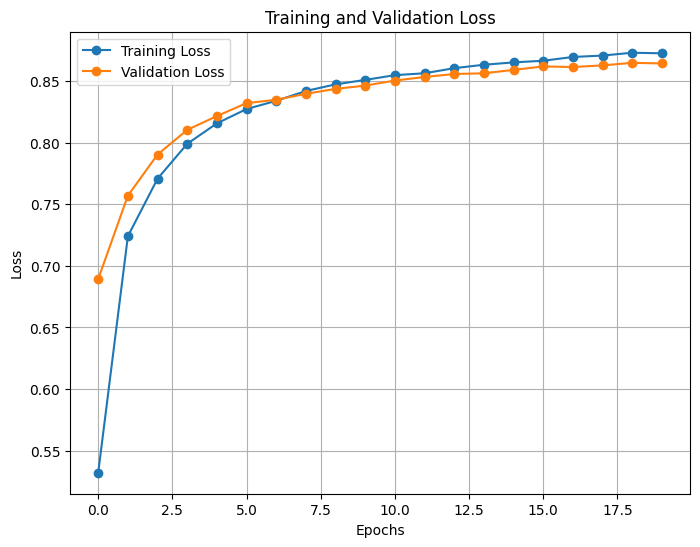

loss was: 0.39087010771036146  accuracy was: 0.8594


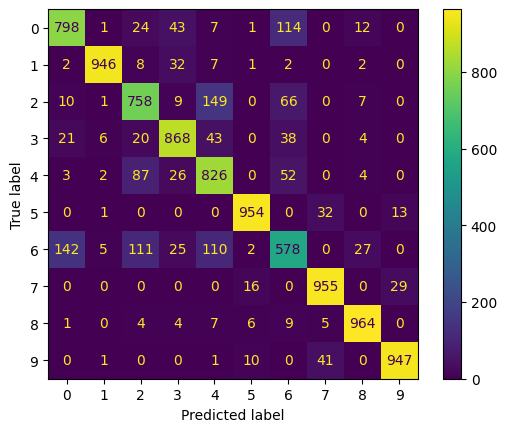

In [94]:
model = DeepConvNet()
criterion, optimizer, lr_scheduler = intialiseParameters(model, LR_OPTIMIZER, GAMMA_LR,WEIGHT_DECAY_FACTOR, MILESTONES)
train_info = train_model(model, fullImg_train_dataloader, fullImg_validation_dataloader, criterion, optimizer, 
                         lr_scheduler, BATCH_SIZE, EPOCHS)
torch.save(model.state_dict(), "./mlp.pth")
plot_losses(train_info["train_loss"], train_info["validation_loss"])
plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"])
test_model(model, fullImg_test_dataloader, criterion, BATCH_SIZE)
